In [1]:
# Import necessary libraries for data analysis and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score
)


In [2]:
# Load the application data and credit record data from CSV files
app_df = pd.read_csv("application_record.csv")
credit_df = pd.read_csv("credit_record.csv")


In [3]:
# Remove rows with 'X' status (no months on book)
credit_df = credit_df[credit_df["STATUS"] != "X"]

# Replace 'C' (Closed) with 0, and convert to integer
credit_df["STATUS"] = credit_df["STATUS"].replace({"C": "0"}).astype(int)

# Create a binary target variable: 1 if STATUS >= 2 (overdue), else 0
credit_df["TARGET"] = np.where(credit_df["STATUS"] >= 2, 1, 0)

# Aggregate TARGET per applicant ID: if any bad record exists, mark as 1
target_df = credit_df.groupby("ID")["TARGET"].max().reset_index()


In [4]:
# Merge application data with aggregated target labels from credit data
# Drop the ID column after merging
data = pd.merge(app_df, target_df, on="ID", how="inner").drop("ID", axis=1)


In [5]:
# Identify categorical (object) columns
categorical_cols = data.select_dtypes(include=["object"]).columns

# Convert categorical variables into dummy/indicator variables
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)


In [6]:
# Convert negative birth days to positive (since it's days before today)
if "DAYS_BIRTH" in data.columns:
    data["DAYS_BIRTH"] = data["DAYS_BIRTH"].apply(abs)


In [7]:
# Drop columns with more than 50% missing values
data = data.dropna(thresh=len(data) * 0.5, axis=1)

# Fill remaining missing values with the column median
data = data.fillna(data.median(numeric_only=True))


In [8]:
# Separate features (X) and target (y)
X = data.drop("TARGET", axis=1)
y = data["TARGET"]

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
# Initialize and train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Print accuracy and classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9827846572032618

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6502
           1       0.58      0.18      0.28       120

    accuracy                           0.98      6622
   macro avg       0.78      0.59      0.63      6622
weighted avg       0.98      0.98      0.98      6622



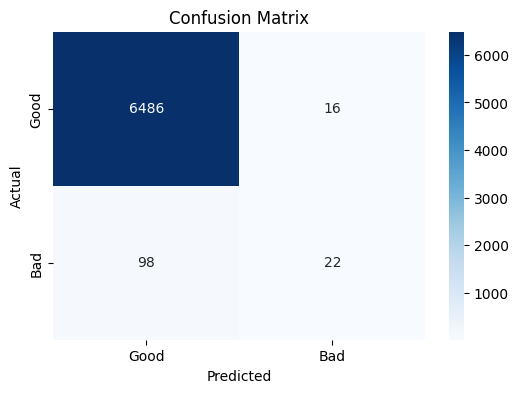

In [11]:
# Generate and visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Good", "Bad"], yticklabels=["Good", "Bad"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


AUC Score: 0.8006


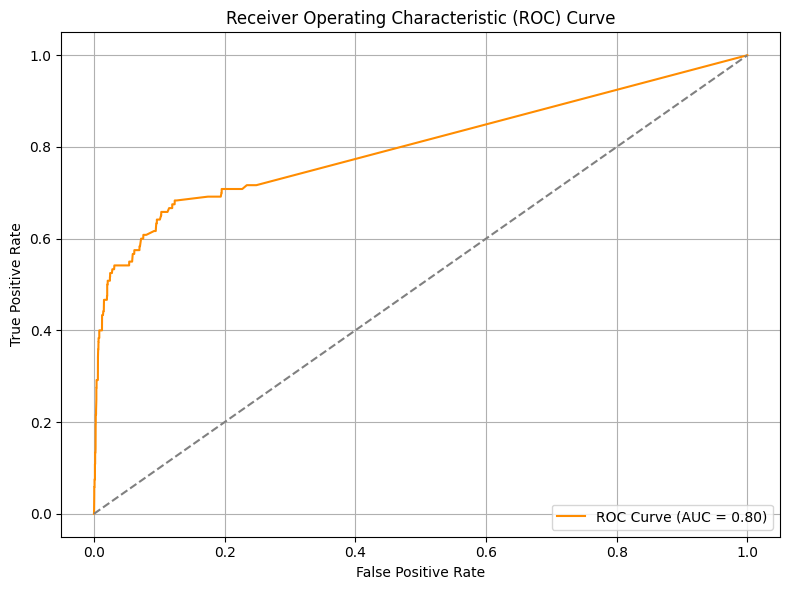

In [12]:
# Get predicted probabilities for ROC curve
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate and print AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


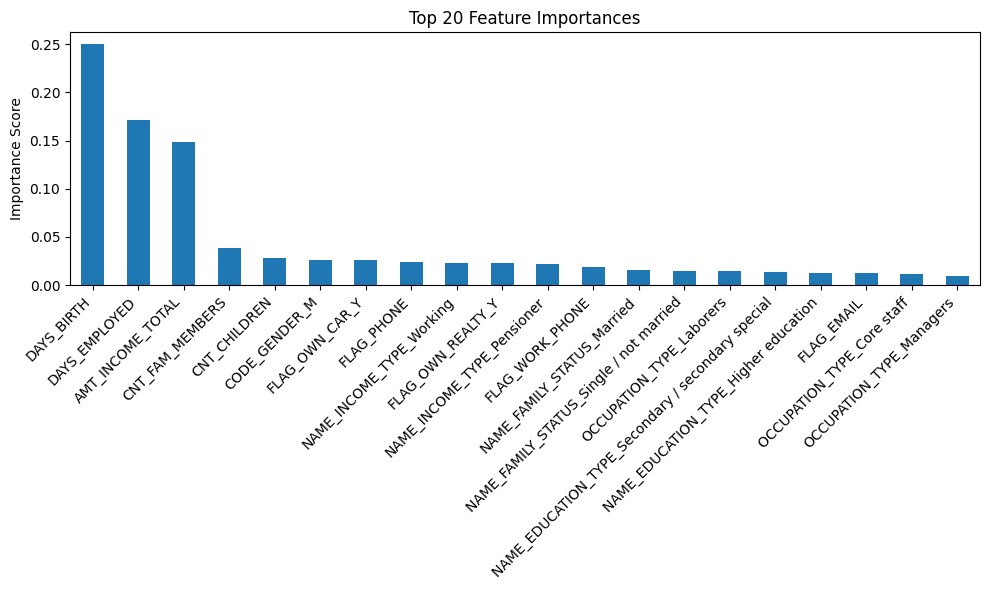

In [13]:
# Get feature importances from the trained model
importances = model.feature_importances_
features = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
features.head(20).plot(kind="bar")
plt.title("Top 20 Feature Importances")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
